In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import json
import torch
from sentence_transformers import SentenceTransformer
from transformers import AutoModel, AutoTokenizer
from transformers import AutoModel

from collections import defaultdict

#### Moral foundations
1. Care/Virtue (compassion, empathy, kindness)
2. Harm/Vice (harm, suffer, hurt)
3. Fairness/Virtue (equality, fairness, justice)
4. Cheating/Vice (cheat, unfair, cheating)
5. Loyalty/Virtue (loyalty, patriot, team player)
6. Betrayal/Vice (traitor, disloyal, treason)
7. Authority/Virtue (respect, obey, authority)
8. Subversion/Vice (disrespect, disobey, chaos)
9. Purity/Virtue (sanctity, sacred, purity)
10. Degradation/Vice (impurity, degradation, depravity)

### Load Dataset

- Character dialogues
- Moral Character Foundations

In [71]:
# Read the JSON file of chatracter dialogues
with open("../data/dialogue.json", "r") as file:
    raw_dialogue = json.load(file)

# Create a nested dictionary structure
dialogue = {}

for movie, data in raw_dialogue.items():
    # Initialize movie dictionary if not exists
    if movie not in dialogue:
        dialogue[movie] = {}
        
    # If data is a dictionary (contains character information)
    if isinstance(data, dict):
        for character, lines in data.items():
            if isinstance(lines, list):
                dialogue[movie][character] = lines
    # If data is a list (direct dialogues without character info)
    elif isinstance(data, list):
        dialogue[movie]['unknown'] = data

In [72]:
# Loading moral foundations dictionary
moral_dict = pd.read_csv("../data/mfd_v2.csv")

# Convert DataFrame to dictionary for O(1) lookup
moral_word_dict = dict(zip(moral_dict['word'].str.lower(), moral_dict['category']))


# Group words by category
category_words = defaultdict(list)
for _, row in moral_dict.iterrows():
    category_words[row['category']].append(row['word'])


### Movies

#### Movies I've seen

##### Adult Movies

- Chronicles of Narnia: The Lion, the Witch and the Wardrobe
- Interstellar
- John Wick
- Les Miserables
- Moneyball
- Pirates of the Caribbean
- Pirates of the Caribbean: Dead Man's Chest
- Star Wars: A New Hope
- Star Wars: Attack of the Clones
- Star Wars: Return of the Jedi
- Star Wars: The Empire Strikes Back
- Star Wars: The Force Awakens
- Star Wars: The Phantom Menace
- The Avengers
- Constantine

#####  Kids Movies
- Zootopia
- How to Train Your Dragon
- How to Train Your Dragon 2
- Frozen
- Cars 2
- Up
- Wall-E


In [73]:
print("Movies in dataset:")
for movie in dialogue:
    print(movie)

Movies in dataset:
10 Things I Hate About You
12
12 and Holding
12 Monkeys
12 Years a Slave
127 Hours
1492: Conquest of Paradise
15 Minutes
17 Again
187
2001: A Space Odyssey
2012
28 Days Later
30 Minutes or Less
42
44 Inch Chest
48 Hrs.
50-50
500 Days of Summer
8MM
9
A Few Good Men
A Most Violent Year
A Prayer Before Dawn
A Quiet Place
A Scanner Darkly
A Serious Man
Above the Law
Absolute Power
Abyss, The
Ace Ventura: Pet Detective
Adaptation
Addams Family, The
Adjustment Bureau, The
Adventures of Buckaroo Banzai Across the Eighth Dimension, The
Affliction
After School Special
After.Life
Agnes of God
Air Force One
Airplane
Airplane 2: The Sequel
Aladdin
Ali
Alien
Alien 3
Alien Nation
Alien vs. Predator
Alien: Resurrection
Aliens
All About Eve
All About Steve
All the King's Men
All the President's Men
Almost Famous
Alone in the Dark
Amadeus
Amelia
American Beauty
American Gangster
American Graffiti
American History X
American Hustle
American Madness
American Milkshake
American Outlaws


Let's pick a movie to analyze

In [153]:
# movie_dialogue = dialogue["Chronicles of Narnia: The Lion, the Witch and the Wardrobe"]
# movie_dialogue = dialogue["Interstellar"]
# movie_dialogue = dialogue["John Wick"]
# movie_dialogue = dialogue["Les Miserables"]
# movie_dialogue = dialogue["Moneyball"]
# movie_dialogue = dialogue["Pirates of the Caribbean"]
# movie_dialogue = dialogue["Pirates of the Caribbean: Dead"]
# movie_dialogue = dialogue["Star Wars: A New Hope"]
# movie_dialogue = dialogue["Star Wars: Attack of the Clones"]
# movie_dialogue = dialogue["Star Wars: Return of the Jedi"]
# movie_dialogue = dialogue["Star Wars: The Empire Strikes Back"]
# movie_dialogue = dialogue["Star Wars: The Force Awakens"]
# movie_dialogue = dialogue["Star Wars: The Phantom Menace"]
# movie_dialogue = dialogue["Avengers, The (2012)"]
# movie_dialogue = dialogue["Constantine"]
movie_dialogue = dialogue["Beauty and the Beast"]

In [154]:
movie_dialogue.keys()

dict_keys(['NARRATOR', 'BELLE', 'JEAN', 'GASTON', 'LEFOU', 'ALL', 'MAURICE', 'LUMI', 'COGSWORTH', 'CADENZA', 'CHIP', 'THE BEAST', 'PLUMETTE', 'GARDEROBE', 'MRS'])

### Descriptive Analysis

In [155]:
# Initialize a dictionary to store the counts
character_word_counts = defaultdict(lambda: defaultdict(int))

# Iterate through each character and their lines
for character, lines in movie_dialogue.items():
    for line in lines:
        # Tokenize the line into words
        words = line.lower().split()
        for word in words:
            # Check if the word is in the moral_word_dict
            character_word_counts[character][word] += 1

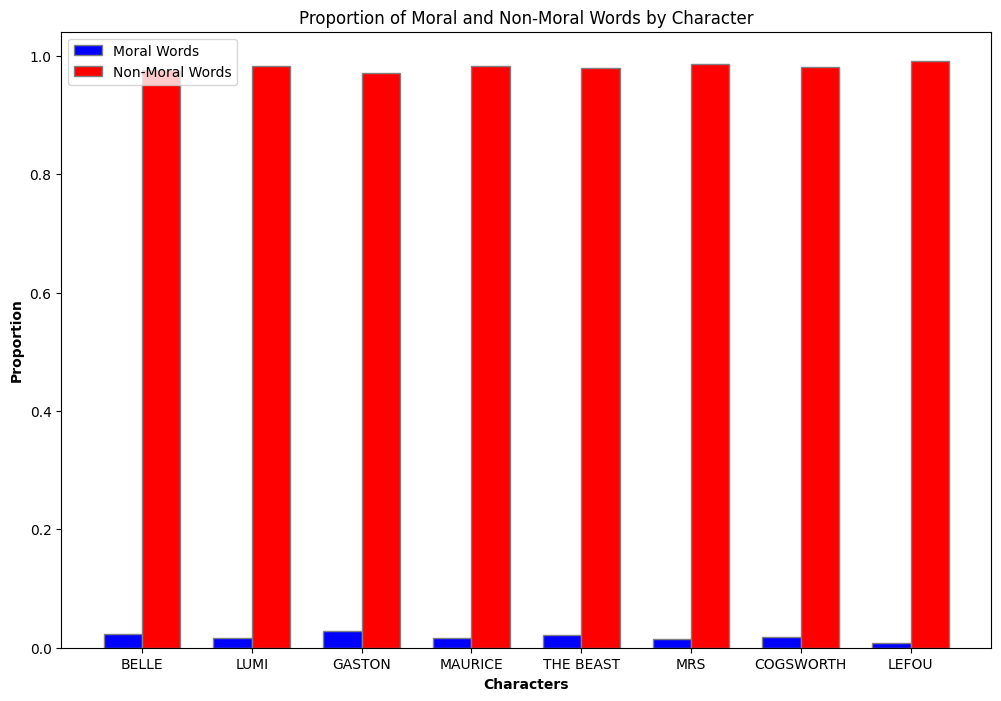

In [156]:
import matplotlib.pyplot as plt

# List of characters to analyze
# List of 8 characters with the highest number of speeches in movie_dialogue
characters_to_analyze = sorted(movie_dialogue.keys(), key=lambda character: len(movie_dialogue[character]), reverse=True)[:8]

# Initialize dictionaries to store word counts
total_words = {}
moral_words = {}

# Calculate total and moral word counts for each character
for character in characters_to_analyze:
    total_words[character] = sum(character_word_counts[character].values())
    moral_words[character] = sum(count for word, count in character_word_counts[character].items() if word in moral_word_dict)

# Calculate proportions
proportions = {character: {'moral': moral_words[character] / total_words[character], 
                           'non_moral': 1 - (moral_words[character] / total_words[character])} 
               for character in characters_to_analyze}

# Plot the proportions
fig, ax = plt.subplots(figsize=(10, 7))

# Bar width
bar_width = 0.35

# Positions of the bars on the x-axis
r1 = range(len(characters_to_analyze))
r2 = [x + bar_width for x in r1]

# Create bars
ax.bar(r1, [proportions[character]['moral'] for character in characters_to_analyze], color='b', width=bar_width, edgecolor='grey', label='Moral Words')
ax.bar(r2, [proportions[character]['non_moral'] for character in characters_to_analyze], color='r', width=bar_width, edgecolor='grey', label='Non-Moral Words')

# Add labels
ax.set_xlabel('Characters', fontweight='bold')
ax.set_ylabel('Proportion', fontweight='bold')
ax.set_title('Proportion of Moral and Non-Moral Words by Character')
ax.set_xticks([r + bar_width/2 for r in range(len(characters_to_analyze))])
ax.set_xticklabels(characters_to_analyze)

# Adjust the graph size
fig.set_size_inches(12, 8)

# Add legend
ax.legend()

# Show plot
plt.show()

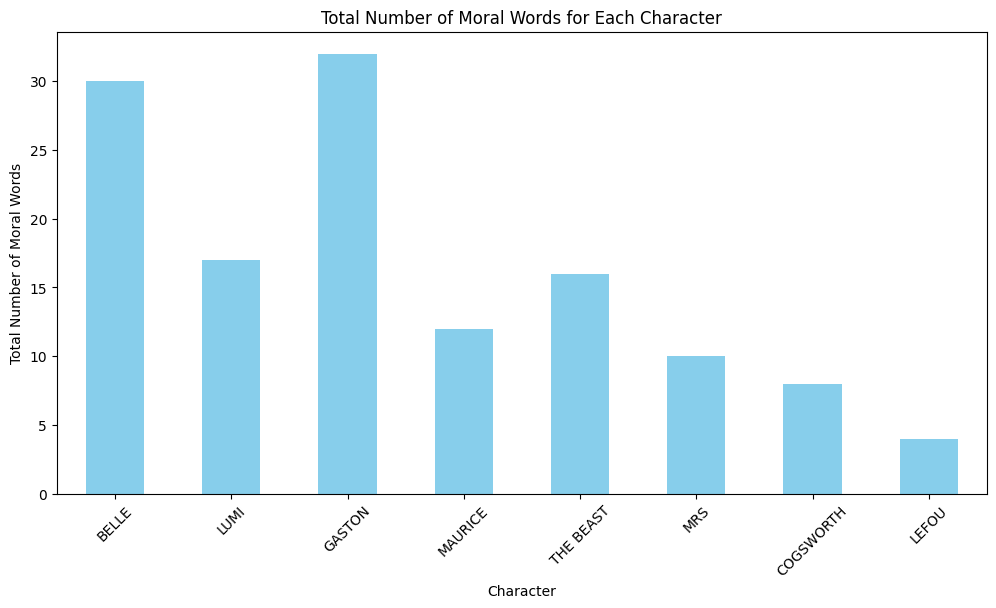

In [157]:
import matplotlib.pyplot as plt


# Plot the number of moral words for each character
plt.figure(figsize=(12, 6))
pd.Series(moral_words).plot(kind='bar', color='skyblue')
plt.xlabel('Character')
plt.ylabel('Total Number of Moral Words')
plt.title('Total Number of Moral Words for Each Character')
plt.xticks(rotation=45)
plt.show()


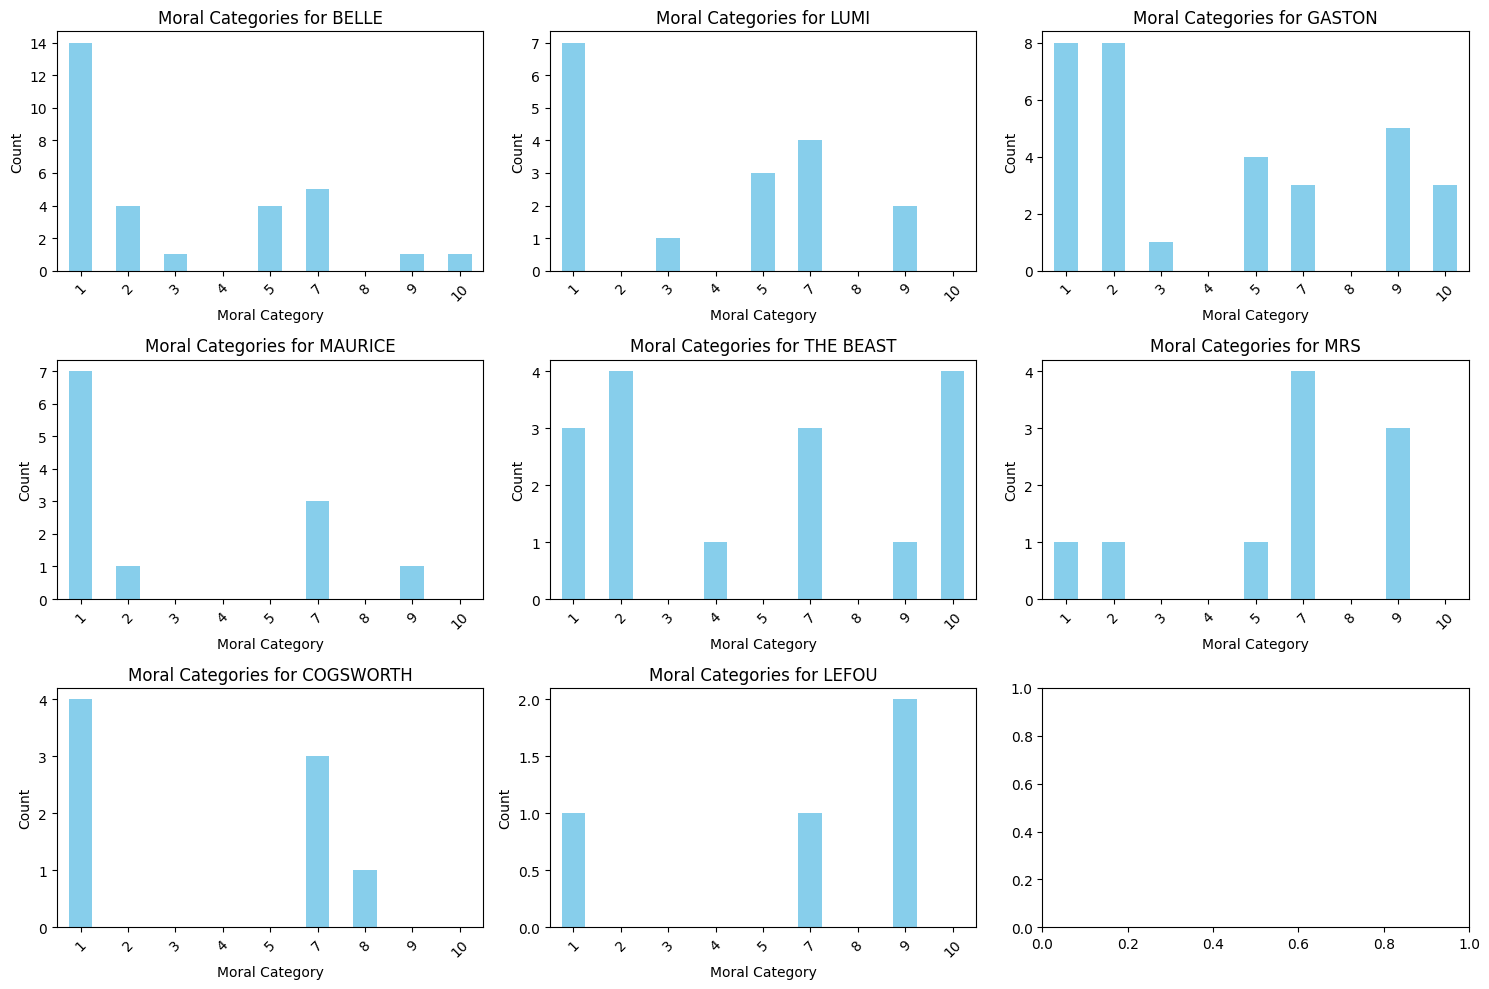

In [158]:
# Initialize a dictionary to store the counts of moral categories for each character
character_moral_categories = defaultdict(lambda: defaultdict(int))

# Iterate through each character and their word counts
for character in characters_to_analyze:
    for word, count in character_word_counts[character].items():
        if word in moral_word_dict:
            category = moral_word_dict[word]
            character_moral_categories[character][category] += count

# Convert the nested dictionary to a DataFrame
df_character_moral_categories = pd.DataFrame(character_moral_categories).fillna(0).astype(int)

# Sort the DataFrame by index to ensure the x-axis is in order
df_character_moral_categories = df_character_moral_categories.sort_index()

# Plot the moral categories for each character in a grid
fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # 3 rows, 3 columns

for i, character in enumerate(characters_to_analyze):
    ax = axes[i // 3, i % 3]  # Determine the position in the grid
    df_character_moral_categories[character].plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title(f'Moral Categories for {character}')
    ax.set_xlabel('Moral Category')
    ax.set_ylabel('Count')
    ax.set_xticklabels(df_character_moral_categories.index, rotation=45)

plt.tight_layout()
plt.show()

### Approaches
1. Word frequency model (raw)
2. WF model (tf-idf)
3. WF semantic model

### Method 1 : Word frequency model (raw)

In [159]:
# Initialize a dictionary to store the counts
character_word_counts = defaultdict(lambda: defaultdict(int))

# Iterate through each character and their lines
for character, lines in movie_dialogue.items():
    for line in lines:
        # Tokenize the line into words
        words = line.lower().split()
        for word in words:
            # Check if the word is in the moral_word_dict
            if word in moral_word_dict:
                character_word_counts[character][word] += 1

# Convert the nested dictionary to a DataFrame
df_character_word_counts = pd.DataFrame(character_word_counts).fillna(0).astype(int).T

# Reorder columns to match the order of moral foundation words
df_character_word_counts = df_character_word_counts.reindex(columns=moral_word_dict.keys(), fill_value=0)

print(df_character_word_counts)

           compassion  empathy  kindness  caring  generosity  benevolence  \
NARRATOR            0        0         0       0           0            0   
BELLE               0        0         0       0           0            0   
JEAN                0        0         0       0           0            0   
GASTON              0        0         0       0           0            0   
LEFOU               0        0         0       0           0            0   
ALL                 0        0         0       0           0            0   
MAURICE             0        0         0       0           0            0   
LUMI                0        0         0       0           0            0   
COGSWORTH           0        0         0       0           0            0   
THE BEAST           0        0         0       0           0            0   
PLUMETTE            0        0         0       0           0            0   
GARDEROBE           0        0         0       0           0            0   

In [160]:
# Remove columns where all entries are 0
df_character_word_counts = df_character_word_counts.loc[:, (df_character_word_counts != 0).any(axis=0)]

print(df_character_word_counts)

           love  pity  cared  loved  care  heal  help  mother  child  loves  \
NARRATOR      4     0      0      0     0     0     0       0      0      0   
BELLE         5     0      0      1     1     0     3       0      1      0   
JEAN          0     0      0      0     0     0     0       0      0      0   
GASTON        2     0      1      0     2     1     2       0      0      0   
LEFOU         1     0      0      0     0     0     0       0      0      0   
ALL           0     1      0      0     0     0     1       0      0      0   
MAURICE       3     0      0      0     0     0     2       1      0      0   
LUMI          4     0      0      0     1     0     1       0      0      0   
COGSWORTH     4     0      0      0     0     0     0       0      0      0   
THE BEAST     3     0      0      0     0     0     0       0      0      0   
PLUMETTE      0     0      0      0     0     0     0       0      0      0   
GARDEROBE     1     0      0      0     0     0     

/var/folders/4p/8nlm0n094791rk0xf6jzk8ch0000gn/T/ipykernel_21770/2056272012.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(character, (df_pca['PC1'][i], df_pca['PC2'][i]))


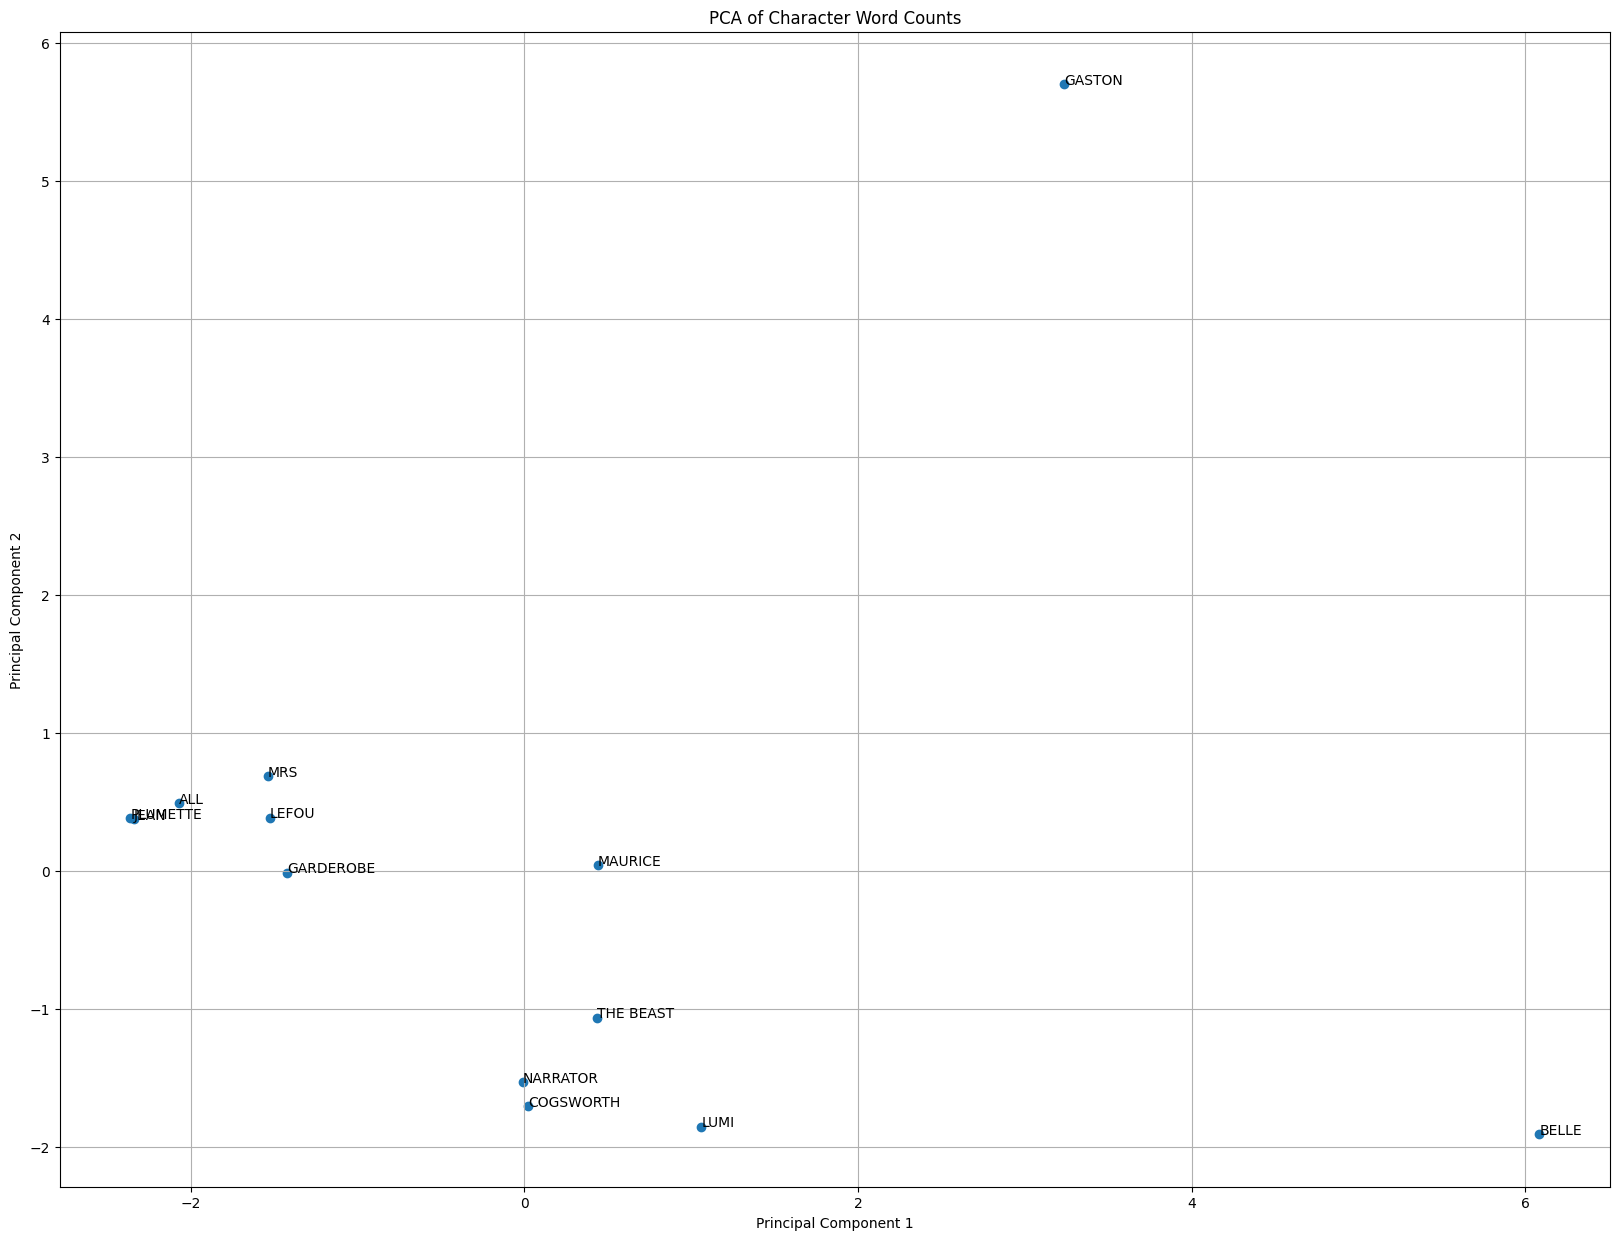

In [161]:
from sklearn.decomposition import PCA

# Initialize PCA with the number of components you want to keep
pca = PCA(n_components=2)  # You can change the number of components as needed

# Fit and transform the data
pca_result = pca.fit_transform(df_character_word_counts)

# Create a DataFrame with the PCA results
df_pca = pd.DataFrame(pca_result, index=df_character_word_counts.index, columns=['PC1', 'PC2'])

plt.figure(figsize=(10, 7))
plt.scatter(df_pca['PC1'], df_pca['PC2'])

for i, character in enumerate(df_pca.index):
    plt.annotate(character, (df_pca['PC1'][i], df_pca['PC2'][i]))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Character Word Counts')
plt.grid(True)
plt.gcf().set_size_inches(20, 15)
plt.show()

### Method 2 : F model (tf-idf)

The **TF-IDF** formula is given by:

$$
\text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)
$$

Where:

1. **Term Frequency (TF)**:
   $$
   \text{TF}(t, d) = \frac{f_{t,d}}{\sum_{t' \in d} f_{t',d}}
   $$

2. **Inverse Document Frequency (IDF)**:
   $$
   \text{IDF}(t, D) = \log\left(\frac{N}{n_t + 1}\right)
   $$

The full formula can also be written as:
$$
\text{TF-IDF}(t, d, D) = \left( \frac{f_{t,d}}{\sum_{t' \in d} f_{t',d}} \right) \times \log\left( \frac{N}{n_t + 1} \right)
$$

**Symbol Definitions**:
- $f_{t,d} $: Frequency of term $ t $ in document $d $.
- $ N $: Total number of documents in the corpus $ D $.
- $ n_t $: Number of documents containing term $t $.
- $ \log $: Natural logarithm (base $ e $) is commonly used.

Process:
- For each character, their dialogue lines are joined into a single string.
- The character's name is stored in the characters list.
- The combined dialogue string is stored in the corpus list.

For each character's dialogue, we calculate how important each word in the moral dictionary is, based on:
- Term Frequency (TF): How often a word appears in the character's dialogue.
- Inverse Document Frequency (IDF): How rare the word is across all characters' dialogues.

In [162]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Prepare the data for TF-IDF
corpus = []
characters = []

for character, lines in movie_dialogue.items():
    characters.append(character)
    corpus.append(' '.join(lines))

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(vocabulary=moral_word_dict.keys())

# Fit and transform the data
tfidf_matrix = vectorizer.fit_transform(corpus)

# Convert the TF-IDF matrix to a DataFrame
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), index=characters, columns=vectorizer.get_feature_names_out())

# Remove columns where all entries are 0
df_tfidf = df_tfidf.loc[:, (df_tfidf != 0).any(axis=0)]

/var/folders/4p/8nlm0n094791rk0xf6jzk8ch0000gn/T/ipykernel_21770/549551980.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(character, (df_pca['PC1'][i], df_pca['PC2'][i]))


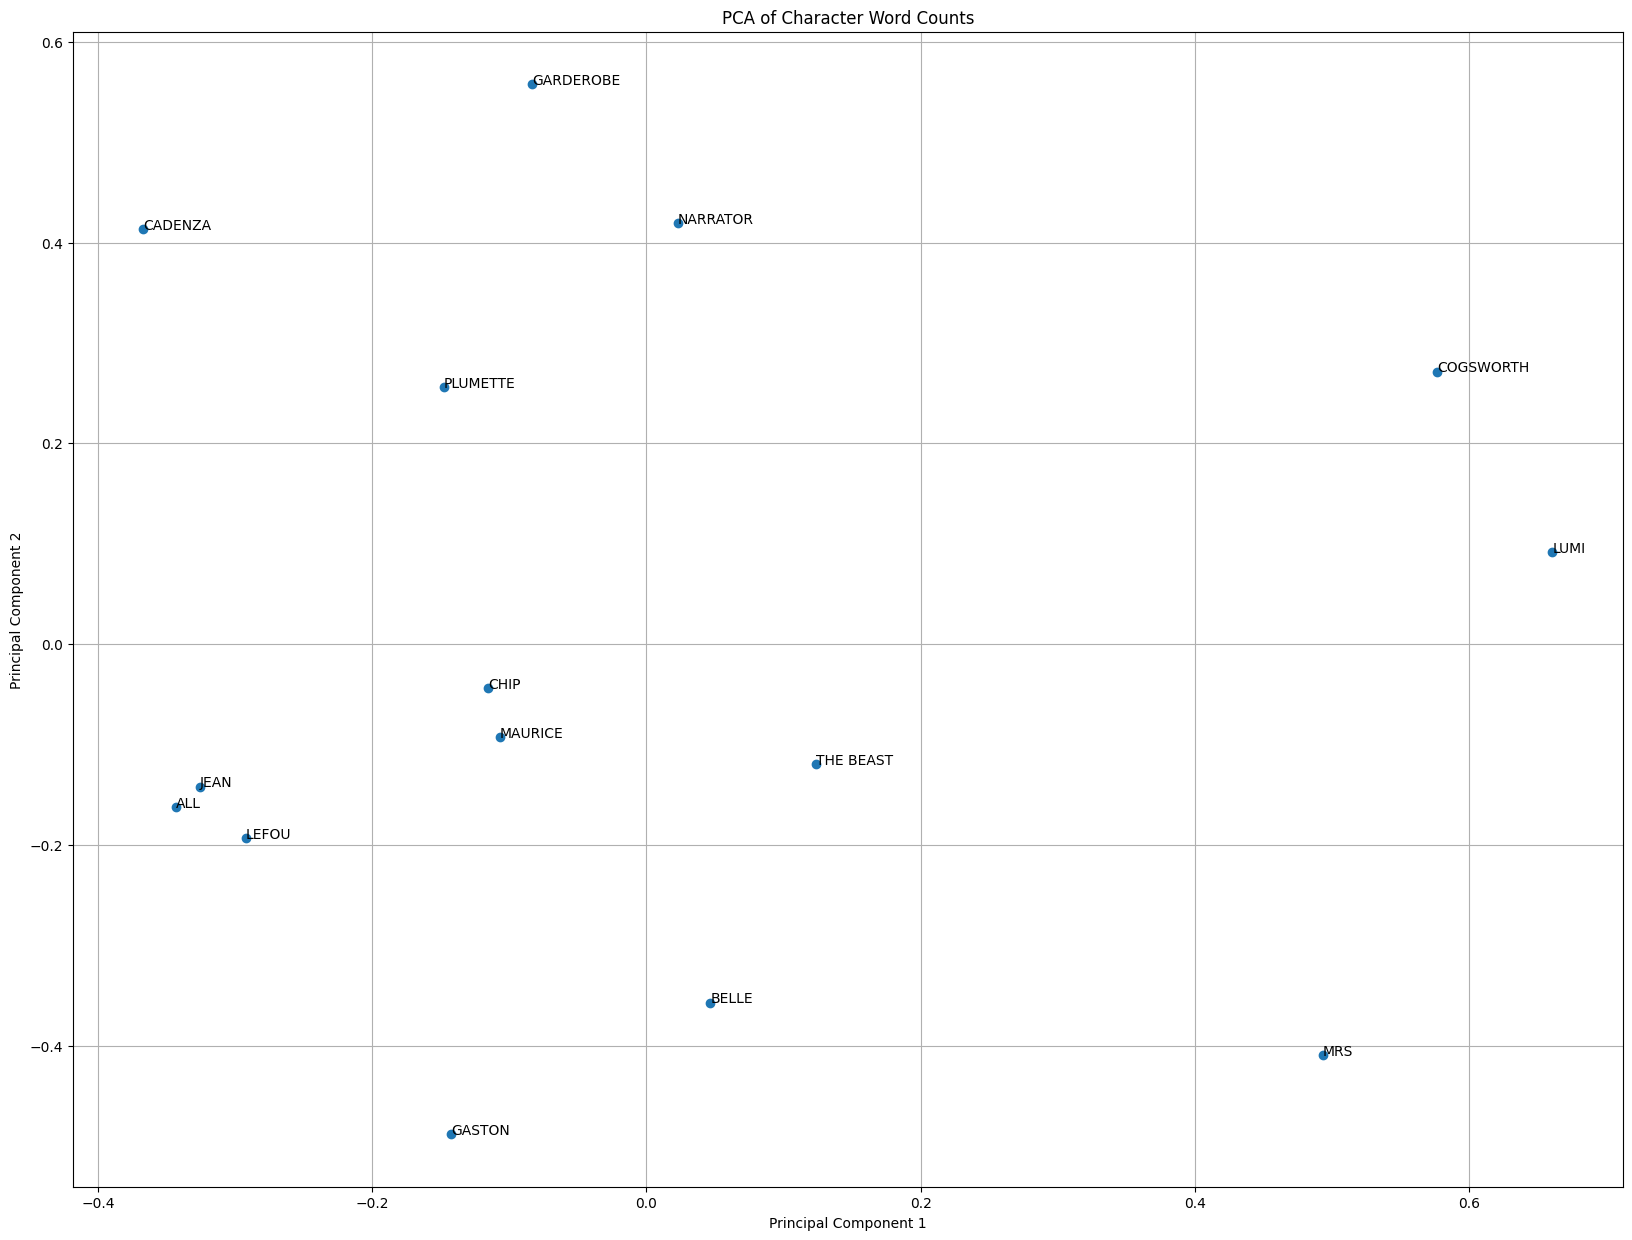

In [163]:
# Initialize PCA with the number of components you want to keep
pca = PCA(n_components=2)  # You can change the number of components as needed

# Fit and transform the data
pca_result = pca.fit_transform(df_tfidf)

# Create a DataFrame with the PCA results
df_pca = pd.DataFrame(pca_result, index=df_tfidf.index, columns=['PC1', 'PC2'])

plt.figure(figsize=(10, 7))
plt.scatter(df_pca['PC1'], df_pca['PC2'])

for i, character in enumerate(df_pca.index):
    plt.annotate(character, (df_pca['PC1'][i], df_pca['PC2'][i]))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Character Word Counts')
plt.grid(True)
plt.gcf().set_size_inches(20, 15)
plt.show()

### Method 3 : WF semantic model

#### Word embedding model
1. Word2Vec
2. GloVe
3. FastText

#### Word2Vec

In [164]:
import numpy as np
from gensim.models import Word2Vec

# Step 1: Normalize the word counts for each character
df_normalized_counts = df_character_word_counts.div(df_character_word_counts.sum(axis=1), axis=0)

# Step 2: Train or load a Word2Vec model
# For demonstration, let's train a simple Word2Vec model on the corpus
sentences = [line.lower().split() for lines in movie_dialogue.values() for line in lines]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Step 3: Compute weighted embeddings for each character
character_embeddings = {}

for character in df_normalized_counts.index:
    weighted_embedding = np.zeros(word2vec_model.vector_size)  # Initialize with zeros
    for word in df_normalized_counts.columns:
        if word in word2vec_model.wv:
            weighted_embedding += df_normalized_counts.loc[character, word] * word2vec_model.wv[word]
    character_embeddings[character] = weighted_embedding

/var/folders/4p/8nlm0n094791rk0xf6jzk8ch0000gn/T/ipykernel_21770/1074340535.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(character, (df_pca_embeddings['PC1'][i], df_pca_embeddings['PC2'][i]))


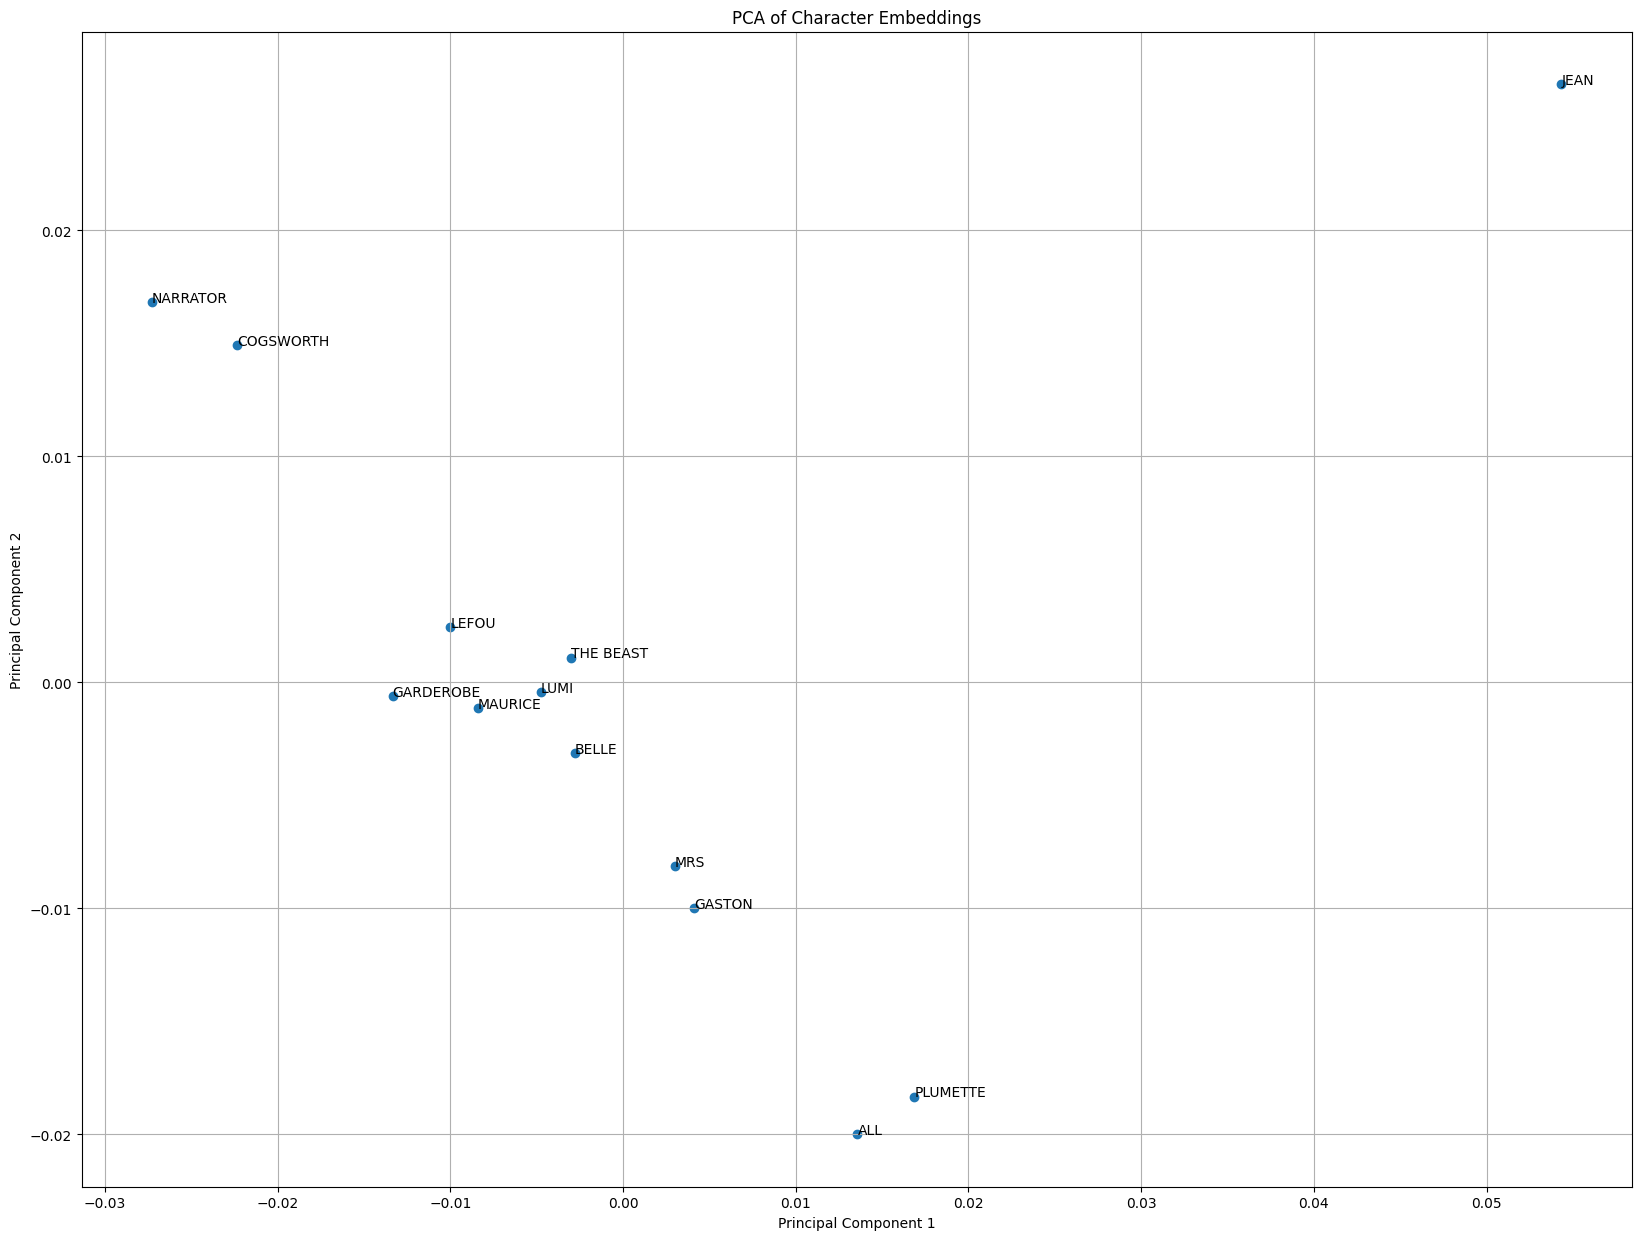

In [165]:
# Convert the character embeddings to a DataFrame
df_embeddings = pd.DataFrame(character_embeddings).T

# Apply PCA to the embeddings
pca_embeddings = PCA(n_components=2)
pca_result_embeddings = pca_embeddings.fit_transform(df_embeddings)

# Create a DataFrame with the PCA results
df_pca_embeddings = pd.DataFrame(pca_result_embeddings, index=df_embeddings.index, columns=['PC1', 'PC2'])

# Plot the PCA results
plt.figure(figsize=(10, 7))
plt.scatter(df_pca_embeddings['PC1'], df_pca_embeddings['PC2'])

for i, character in enumerate(df_pca_embeddings.index):
    plt.annotate(character, (df_pca_embeddings['PC1'][i], df_pca_embeddings['PC2'][i]))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Character Embeddings')
plt.grid(True)
plt.gcf().set_size_inches(20, 15)
plt.show()

#### GloVe

https://nlp.stanford.edu/projects/glove/ 

/var/folders/4p/8nlm0n094791rk0xf6jzk8ch0000gn/T/ipykernel_21770/1077047979.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(character, (df_pca_embeddings['PC1'][i], df_pca_embeddings['PC2'][i]))


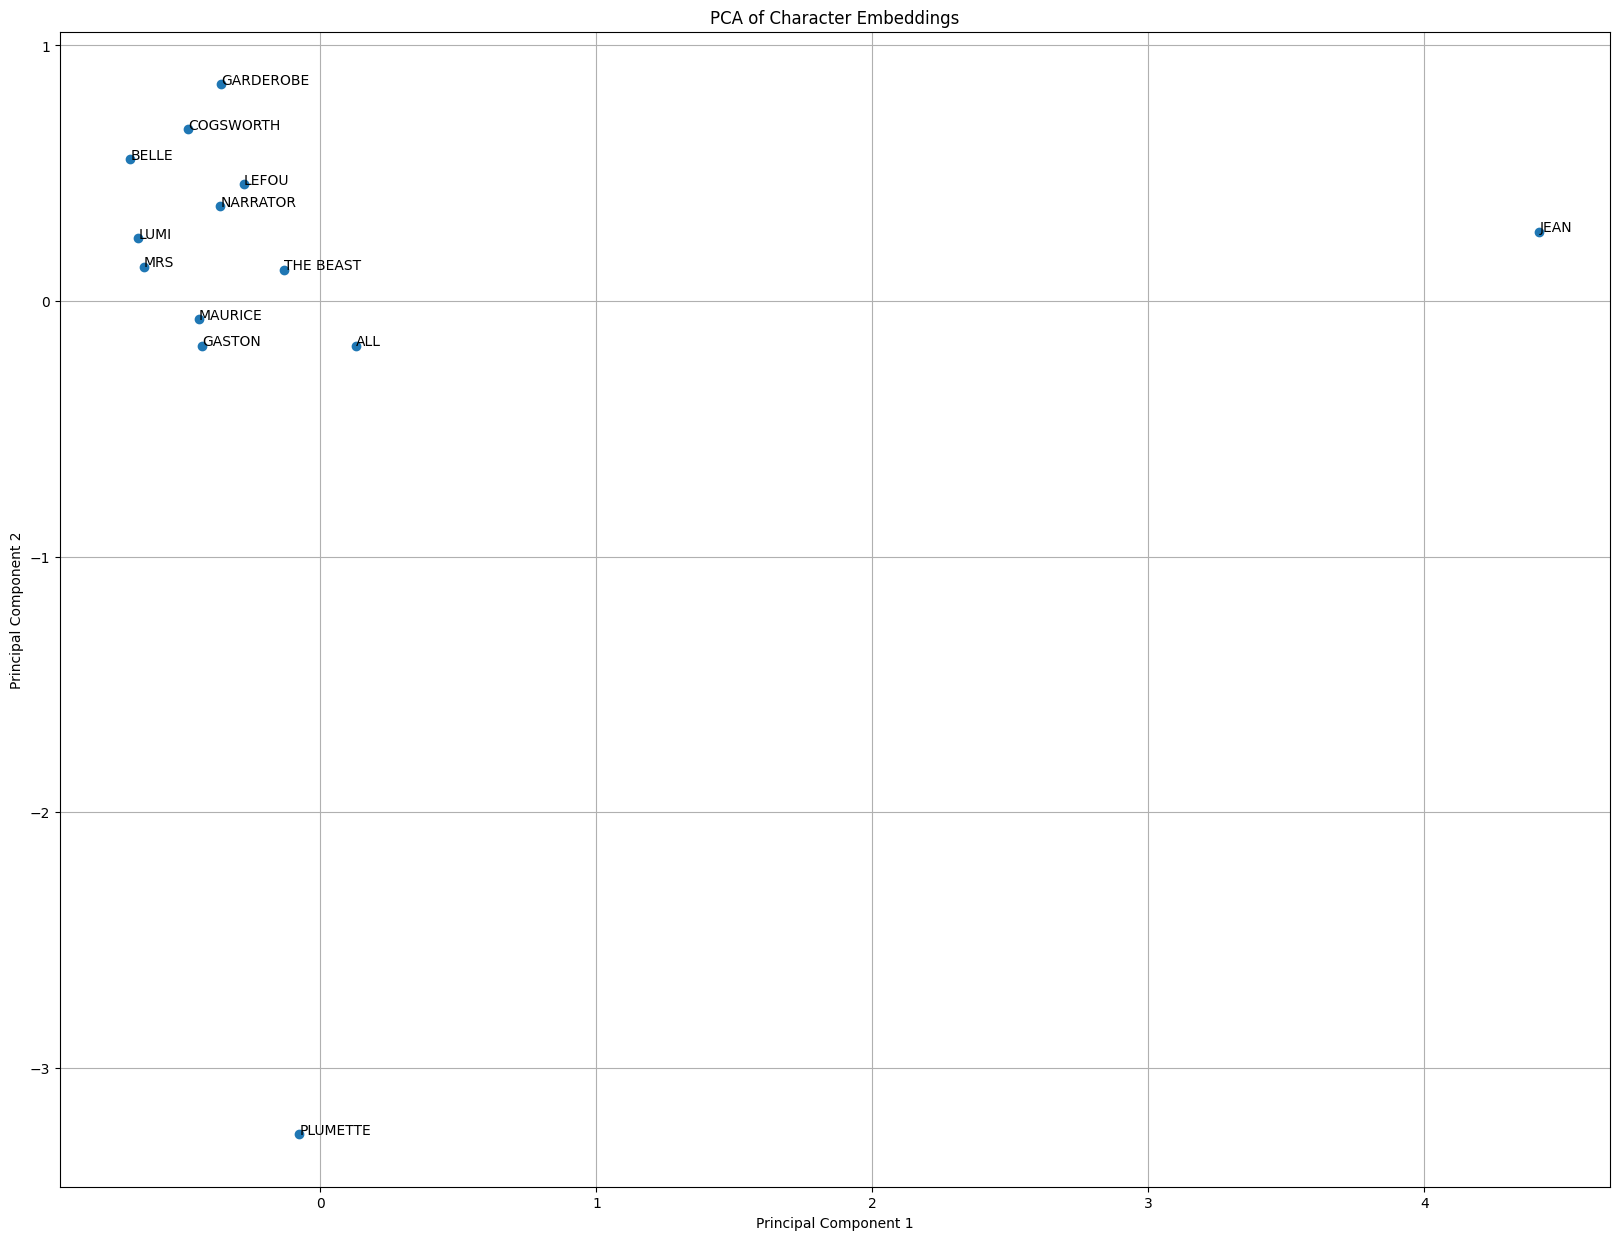

In [166]:
import numpy as np
import pandas as pd

# Step 1: Normalize the word counts for each character
df_normalized_counts = df_character_word_counts.div(df_character_word_counts.sum(axis=1), axis=0)

# Step 2: Load GloVe embeddings
glove_embeddings = {}
glove_path = "../model/glove.6B/glove.6B.100d.txt" # Path to the GloVe file

with open(glove_path, 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        glove_embeddings[word] = vector

# Step 3: Compute weighted embeddings for each character
character_embeddings = {}

for character in df_normalized_counts.index:
    weighted_embedding = np.zeros(100)  # GloVe embeddings are 100-dimensional
    for word in df_normalized_counts.columns:
        if word in glove_embeddings:
            weighted_embedding += df_normalized_counts.loc[character, word] * glove_embeddings[word]
    character_embeddings[character] = weighted_embedding

# Convert the character embeddings to a DataFrame
df_embeddings = pd.DataFrame(character_embeddings).T

# Apply PCA to the embeddings
pca_embeddings = PCA(n_components=2)
pca_result_embeddings = pca_embeddings.fit_transform(df_embeddings)

# Create a DataFrame with the PCA results
df_pca_embeddings = pd.DataFrame(pca_result_embeddings, index=df_embeddings.index, columns=['PC1', 'PC2'])

# Plot the PCA results
plt.figure(figsize=(10, 7))
plt.scatter(df_pca_embeddings['PC1'], df_pca_embeddings['PC2'])

for i, character in enumerate(df_pca_embeddings.index):
    plt.annotate(character, (df_pca_embeddings['PC1'][i], df_pca_embeddings['PC2'][i]))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Character Embeddings')
plt.grid(True)
plt.gcf().set_size_inches(20, 15)
plt.show()